# Задание 2

## Описание

По данным addicts0.xls проанализировать на предмет выбросов индексы тяжести.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import f
import plotly.express as px

In [3]:
df = pd.read_excel('addicts0.xls', sheet_name=1)
necessary_columns = ['asi1_med', 'asi2_emp', 'asi4_dr']
df = df[necessary_columns]
df.fillna(df.mean(), inplace=True)

## Решение

In [4]:
def calculate_mean(df):
    return df.sum().to_numpy() / len(df)
     

def calculate_cov_matrix(df):
    centered = df - calculate_mean(df)
    return centered.apply(lambda row: np.outer(row, row), axis=1).sum() / (len(df) - 1)
     

def calculate_mahalanobis_square_distance(x, df):
    d = x - calculate_mean(df)
    cov_matrix = calculate_cov_matrix(df)
    return d.dot(np.linalg.inv(cov_matrix).dot(d))
     

def calculate_statistics(x, df):
    n = len(df)
    p = len(df.columns)
    return ((n - p) * n) / ((n ** 2 - 1) * p) * calculate_mahalanobis_square_distance(x, df)
     

def calculate_p_value(index, df):
    x = df.loc[index].to_numpy()
    reduced_df = df.drop([index])

    statistics = calculate_statistics(x, reduced_df)

    n = len(reduced_df)
    p = len(reduced_df.columns)

    # Вычисление степени свободы: [количество переменных] и [количество наблюдений минус количество переменных]
    dfn, dfd = p, n - p

    # Вычисление P-значения, используя кумулятивное распределение Фишера (F-распределение)
    return 1 - f.cdf(statistics, dfn=dfn, dfd=dfd)
     

def mark_outliers(df, alpha = 0.01):
    while True:
        filtered_df = df[~df['is_outlier']]
        filtered_df = filtered_df.drop(columns=['is_outlier'])
        p_values = filtered_df.apply(lambda row: calculate_p_value(row.name, filtered_df), axis=1)

        if p_values.min() >= alpha:
            break

        print(f'{p_values.idxmin()}: {df.loc[p_values.idxmin()].drop("is_outlier").to_numpy()}')
        df.loc[p_values.idxmin(), 'is_outlier'] = True

In [5]:
df['is_outlier'] = False
mark_outliers(df)

46: [0.0 1.0 0.66]
268: [0.0 1.0 0.09]
98: [0.97 0.5 0.19]
219: [0.0 1.0 0.11]
85: [0.0 0.0 0.2]
170: [1.0 1.0 0.38]
145: [0.83 1.0 0.41]
147: [0.0 1.0 0.12]
222: [0.0 0.85 0.12]
6: [0.0 1.0 0.42]


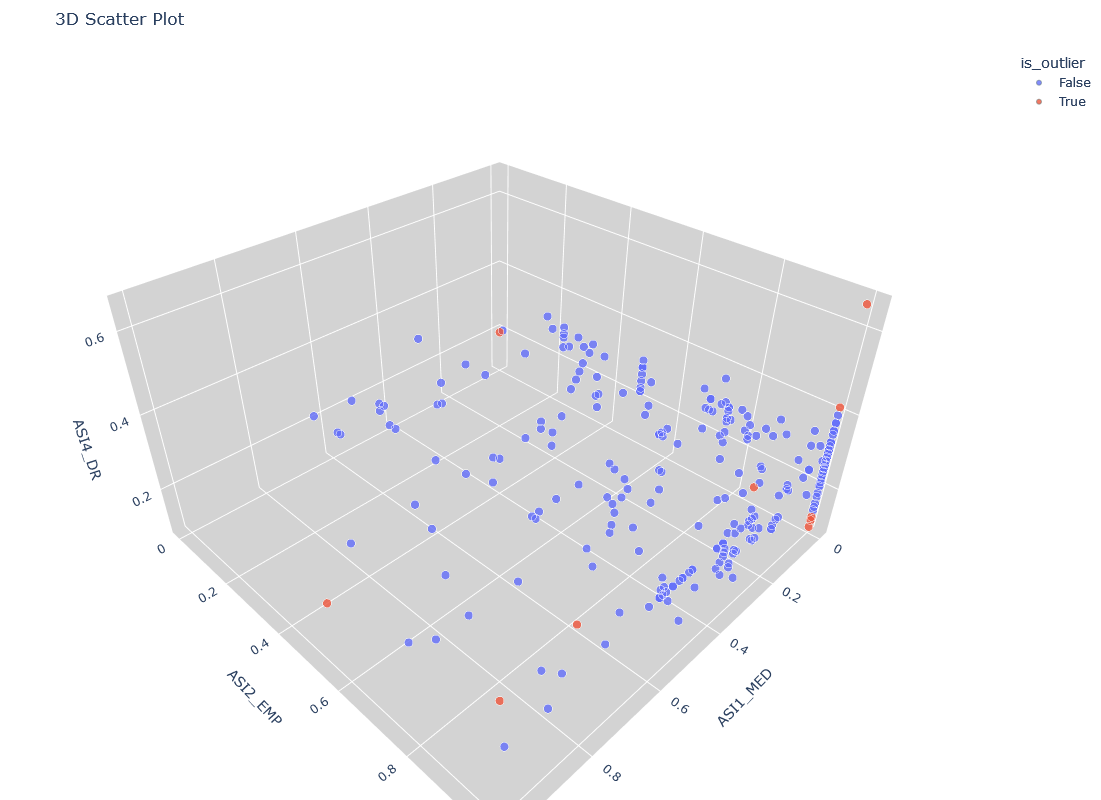

In [10]:
# asi1_med -- медицинский статус
# asi2_emp -- социальный статус
# asi4_dr -- употребление наркотиков
fig = px.scatter_3d(df, x='asi1_med', y='asi2_emp', z='asi4_dr', color='is_outlier')

fig.update_traces(marker=dict(size=5, 
                              opacity=0.8, 
                              line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(title='3D Scatter Plot',
                  scene=dict(
                      xaxis_title='ASI1_MED',
                      yaxis_title='ASI2_EMP',
                      zaxis_title='ASI4_DR',
                      xaxis=dict(backgroundcolor="lightgrey",
                                 gridcolor="white",
                                 showbackground=True,
                                 zerolinecolor="white",),
                      yaxis=dict(backgroundcolor="lightgrey",
                                 gridcolor="white",
                                 showbackground=True,
                                 zerolinecolor="white"),
                      zaxis=dict(backgroundcolor="lightgrey",
                                 gridcolor="white",
                                 showbackground=True,
                                 zerolinecolor="white")),
                  margin=dict(l=0, r=0, b=0, t=50),
                  template='plotly_white',
                  height=800,
                  width=1100)

fig.show()